<a href="https://colab.research.google.com/github/prajeeth15/Captcha-Breaker-using-CNN/blob/main/captchurer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -r requirements.txt

In [2]:
!pip install opencv-python

In [3]:
!unzip extracted_letter_images.zip

Streaming output truncated to the last 5000 lines.
  inflating: extracted_letter_images/R/001058.png  
  inflating: extracted_letter_images/R/001059.png  
  inflating: extracted_letter_images/R/001060.png  
  inflating: extracted_letter_images/R/001061.png  
  inflating: extracted_letter_images/R/001062.png  
  inflating: extracted_letter_images/R/001064.png  
  inflating: extracted_letter_images/R/001065.png  
  inflating: extracted_letter_images/R/001066.png  
  inflating: extracted_letter_images/R/001067.png  
  inflating: extracted_letter_images/R/001068.png  
  inflating: extracted_letter_images/R/001070.png  
  inflating: extracted_letter_images/R/001071.png  
  inflating: extracted_letter_images/R/001073.png  
  inflating: extracted_letter_images/R/001074.png  
  inflating: extracted_letter_images/R/001076.png  
  inflating: extracted_letter_images/R/001078.png  
  inflating: extracted_letter_images/R/001079.png  
  inflating: extracted_letter_images/R/001080.png  
  inflating: 

In [4]:
!unzip generated_captcha_images.zip

Streaming output truncated to the last 5000 lines.
  inflating: generated_captcha_images/YFT5.png  
  inflating: generated_captcha_images/YGX4.png  
  inflating: generated_captcha_images/YHV8.png  
  inflating: generated_captcha_images/YL7K.png  
  inflating: generated_captcha_images/YM2T.png  
  inflating: generated_captcha_images/YQ25.png  
  inflating: generated_captcha_images/YR34.png  
  inflating: generated_captcha_images/YVH5.png  
  inflating: generated_captcha_images/YWMJ.png  
  inflating: generated_captcha_images/YWVU.png  
  inflating: generated_captcha_images/YYG5.png  
  inflating: generated_captcha_images/Z2QD.png  
  inflating: generated_captcha_images/Z2WT.png  
  inflating: generated_captcha_images/Z2ZV.png  
  inflating: generated_captcha_images/Z3DT.png  
  inflating: generated_captcha_images/Z49W.png  
  inflating: generated_captcha_images/Z4Q7.png  
  inflating: generated_captcha_images/Z5Z4.png  
  inflating: generated_captcha_images/Z6DG.png  
  inflating: gener

In [5]:
!python helpers.py

In [6]:
import cv2
import pickle
import os.path
import numpy as np
from imutils import paths
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.core import Flatten, Dense
from helpers import resize_to_fit


LETTER_IMAGES_FOLDER = "extracted_letter_images"
MODEL_FILENAME = "captcha_model.hdf5"
MODEL_LABELS_FILENAME = "model_labels.dat"


# initialize the data and labels
data = []
labels = []

# loop over the input images
for image_file in paths.list_images(LETTER_IMAGES_FOLDER):
    # Load the image and convert it to grayscale
    image = cv2.imread(image_file)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Resize the letter so it fits in a 20x20 pixel box
    image = resize_to_fit(image, 20, 20)

    # Add a third channel dimension to the image to make Keras happy
    image = np.expand_dims(image, axis=2)

    # Grab the name of the letter based on the folder it was in
    label = image_file.split(os.path.sep)[-2]

    # Add the letter image and it's label to our training data
    data.append(image)
    labels.append(label)


# scale the raw pixel intensities to the range [0, 1] (this improves training)
data = np.array(data, dtype="float") / 255.0
labels = np.array(labels)

# Split the training data into separate train and test sets
(X_train, X_test, Y_train, Y_test) = train_test_split(data, labels, test_size=0.25, random_state=0)

# Convert the labels (letters) into one-hot encodings that Keras can work with
lb = LabelBinarizer().fit(Y_train)
Y_train = lb.transform(Y_train)
Y_test = lb.transform(Y_test)

# Save the mapping from labels to one-hot encodings.
# We'll need this later when we use the model to decode what it's predictions mean
with open(MODEL_LABELS_FILENAME, "wb") as f:
    pickle.dump(lb, f)

# Build the neural network!
model = Sequential()

# First convolutional layer with max pooling
model.add(Conv2D(20, (5, 5), padding="same", input_shape=(20, 20, 1), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

# Second convolutional layer with max pooling
model.add(Conv2D(50, (5, 5), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

# Hidden layer with 500 nodes
model.add(Flatten())
model.add(Dense(500, activation="relu"))

# Output layer with 32 nodes (one for each possible letter/number we predict)
model.add(Dense(32, activation="softmax"))

# Ask Keras to build the TensorFlow model behind the scenes
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

# Train the neural network
model.fit(X_train, Y_train, validation_data=(X_test, Y_test), batch_size=32, epochs=10, verbose=1)

# Save the trained model to disk
model.save(MODEL_FILENAME)


Epoch 1/10
909/909 [==============================] - 37s 40ms/step - loss: 0.7664 - accuracy: 0.8126 - val_loss: 0.0491 - val_accuracy: 0.9867
Epoch 2/10
909/909 [==============================] - 36s 39ms/step - loss: 0.0117 - accuracy: 0.9967 - val_loss: 0.0143 - val_accuracy: 0.9959
Epoch 3/10
909/909 [==============================] - 36s 39ms/step - loss: 0.0051 - accuracy: 0.9985 - val_loss: 0.0204 - val_accuracy: 0.9945
Epoch 4/10
909/909 [==============================] - 36s 39ms/step - loss: 0.0022 - accuracy: 0.9993 - val_loss: 0.0137 - val_accuracy: 0.9965
Epoch 5/10
909/909 [==============================] - 36s 39ms/step - loss: 0.0032 - accuracy: 0.9991 - val_loss: 0.0245 - val_accuracy: 0.9944
Epoch 6/10
909/909 [==============================] - 36s 40ms/step - loss: 0.0069 - accuracy: 0.9986 - val_loss: 0.0128 - val_accuracy: 0.9971
Epoch 7/10
909/909 [==============================] - 36s 40ms/step - loss: 1.8300e-04 - accuracy: 0.9999 - val_loss: 0.0139 - val_accur

CAPTCHA text is: 2US3


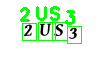

CAPTCHA text is: 8LJ9


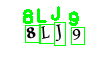

CAPTCHA text is: XHLR


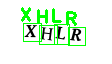

CAPTCHA text is: RSKN


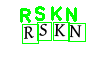

CAPTCHA text is: XS5T


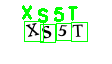

CAPTCHA text is: ZYLR


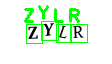

CAPTCHA text is: YXE3


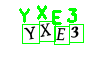

CAPTCHA text is: 2W3R


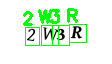

In [8]:
from keras.models import load_model
from helpers import resize_to_fit
from imutils import paths
from google.colab.patches import cv2_imshow
import numpy as np
import imutils
import cv2
import pickle


MODEL_FILENAME = "captcha_model.hdf5"
MODEL_LABELS_FILENAME = "model_labels.dat"
CAPTCHA_IMAGE_FOLDER = "generated_captcha_images"


# Load up the model labels (so we can translate model predictions to actual letters)
with open(MODEL_LABELS_FILENAME, "rb") as f:
    lb = pickle.load(f)

# Load the trained neural network
model = load_model(MODEL_FILENAME)

# Grab some random CAPTCHA images to test against.
# In the real world, you'd replace this section with code to grab a real
# CAPTCHA image from a live website.
captcha_image_files = list(paths.list_images(CAPTCHA_IMAGE_FOLDER))
captcha_image_files = np.random.choice(captcha_image_files, size=(8,), replace=False)

# loop over the image paths
for image_file in captcha_image_files:
    # Load the image and convert it to grayscale
    image = cv2.imread(image_file)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Add some extra padding around the image
    image = cv2.copyMakeBorder(image, 20, 20, 20, 20, cv2.BORDER_REPLICATE)

    # threshold the image (convert it to pure black and white)
    thresh = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]

    # find the contours (continuous blobs of pixels) the image
    contours = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Hack for compatibility with different OpenCV versions
    # contours = contours[0] if imutils.is_cv2() else contours[1]
    contours = contours[0]

    letter_image_regions = []

    # Now we can loop through each of the four contours and extract the letter
    # inside of each one
    for contour in contours:
        # Get the rectangle that contains the contour
        (x, y, w, h) = cv2.boundingRect(contour)

        # Compare the width and height of the contour to detect letters that
        # are conjoined into one chunk
        if w / h > 1.25:
            # This contour is too wide to be a single letter!
            # Split it in half into two letter regions!
            half_width = int(w / 2)
            letter_image_regions.append((x, y, half_width, h))
            letter_image_regions.append((x + half_width, y, half_width, h))
        else:
            # This is a normal letter by itself
            letter_image_regions.append((x, y, w, h))

    # If we found more or less than 4 letters in the captcha, our letter extraction
    # didn't work correcly. Skip the image instead of saving bad training data!
    if len(letter_image_regions) != 4:
        continue

    # Sort the detected letter images based on the x coordinate to make sure
    # we are processing them from left-to-right so we match the right image
    # with the right letter
    letter_image_regions = sorted(letter_image_regions, key=lambda x: x[0])

    # Create an output image and a list to hold our predicted letters
    output = cv2.merge([image] * 3)
    predictions = []

    # loop over the lektters
    for letter_bounding_box in letter_image_regions:
        # Grab the coordinates of the letter in the image
        x, y, w, h = letter_bounding_box

        # Extract the letter from the original image with a 2-pixel margin around the edge
        letter_image = image[y - 2:y + h + 2, x - 2:x + w + 2]

        # Re-size the letter image to 20x20 pixels to match training data
        letter_image = resize_to_fit(letter_image, 20, 20)

        # Turn the single image into a 4d list of images to make Keras happy
        letter_image = np.expand_dims(letter_image, axis=2)
        letter_image = np.expand_dims(letter_image, axis=0)

        # Ask the neural network to make a prediction
        prediction = model.predict(letter_image)

        # Convert the one-hot-encoded prediction back to a normal letter
        letter = lb.inverse_transform(prediction)[0]
        predictions.append(letter)

        # draw the prediction on the output image
        cv2.rectangle(output, (x - 2, y - 2), (x + w + 4, y + h + 4), (0, 255, 0), 1)
        cv2.putText(output, letter, (x - 5, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.55, (0, 255, 0), 2)

    # Print the captcha's text
    captcha_text = "".join(predictions)
    print("CAPTCHA text is: {}".format(captcha_text))

    # Show the annotated image
    cv2_imshow(output)
    cv2.waitKey()